In [1]:
%matplotlib inline
import openpathsampling as paths
import numpy as np
from toy_plot_helpers import ToyPlot

In [2]:
import openpathsampling.toy_dynamics as toys
plot = ToyPlot()
pes = (
    toys.toy_pes.OuterWalls([1.0, 1.0], [0.0, 0.0]) +
    toys.toy_pes.Gaussian(-0.7, [12.0, 12.0], [0.0, 0.4]) +
    toys.toy_pes.Gaussian(-0.7, [12.0, 12.0], [-0.5, -0.5]) +
    toys.toy_pes.Gaussian(-0.7, [12.0, 12.0], [0.5, -0.5])
)

plot.contour_range = np.arange(-1.5, 1.0, 0.1)

topology=paths.ToyTopology(
    n_spatial = 2,
    masses =[1.0, 1.0],
    pes = pes
)

template = paths.Snapshot(
    coordinates=np.array([[-0.5, -0.5]]), 
    velocities=np.array([[0.0,0.0]]),
    potential_energy = 0.0, # Important to set energies dimensionless otherwise kcal/mol is default
    kinetic_energy = 0.0,
    topology=topology
)

integ = toys.toy_integrators.LangevinBAOABIntegrator(dt=0.02, temperature=0.1, gamma=2.5)

options={
    'integ' : integ,
    'n_frames_max' : 5000,
    'nsteps_per_frame' : 10
}

toy_eng = toys.toy_engine.ToyEngine(
    options=options,
    template=template
)
toy_eng.initialized = True

toy_eng.current_snapshot = template
paths.PathMover.engine = toy_eng

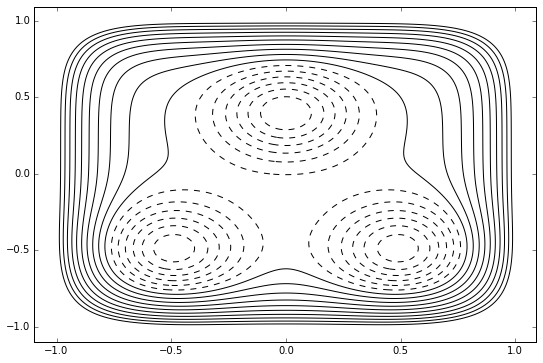

In [3]:
plot.add_pes(pes)
fig = plot.plot()

In [4]:
def circle_sq(snapshot, center):
    return (snapshot.xyz[0][0]-center[0])**2 + (snapshot.xyz[0][1]-center[1])**2
    
opA = paths.CV_Function(name="opA", fcn=circle_sq, center=[-0.5, -0.5])
opB = paths.CV_Function(name="opB", fcn=circle_sq, center=[0.5, -0.5])
opC = paths.CV_Function(name="opC", fcn=circle_sq, center=[0.0, 0.4])

In [5]:
stateA = paths.CVRangeVolume(opA, 0.0, 0.2**2)
stateB = paths.CVRangeVolume(opB, 0.0, 0.2**2)
stateC = paths.CVRangeVolume(opC, 0.0, 0.2**2)
# set up the states; interfaces
interfacesA = paths.VolumeFactory.CVRangeVolumeSet(opA, 0.0,[0.2**2, 0.3**2, 0.4**2, 0.5**2])
interfacesB = paths.VolumeFactory.CVRangeVolumeSet(opB, 0.0,[0.2**2, 0.3**2, 0.4**2, 0.5**2])
interfacesC = paths.VolumeFactory.CVRangeVolumeSet(opC, 0.0,[0.2**2, 0.3**2, 0.4**2, 0.5**2])
# bootstrap out of each state to get initial trajectories
# save the initial trajectories to 3 different files.

In [6]:
# the other option might be to turn this into a class FullBootstrap, but this function seems to work for now
# TODO: move this function into openpathsampling (maybe have a module bootstrap_interfaces?)
import sys
def full_bootstrap(transition, snapshot, engine, extra_interfaces=[], storage=None):
    interface0 = transition.interfaces[0]
    ensemble0 = transition.ensembles[0]
    state = transition.stateA
    first_traj_ensemble = paths.SequentialEnsemble([
        paths.OptionalEnsemble(paths.AllOutXEnsemble(state)),
        paths.AllInXEnsemble(state),
        paths.OptionalEnsemble(paths.AllOutXEnsemble(state) & paths.AllInXEnsemble(interface0)),
        paths.OptionalEnsemble(paths.AllInXEnsemble(interface0)),
        paths.AllOutXEnsemble(interface0),
        paths.OptionalEnsemble(paths.AllOutXEnsemble(state)),
        paths.SingleFrameEnsemble(paths.AllInXEnsemble(state))
    ])
    #print first_traj_ensemble #DEBUG
    engine.current_snapshot = snapshot
    engine.snapshot = snapshot
    print "Building first trajectory"
    sys.stdout.flush()
    first_traj = engine.generate(engine.current_snapshot, [first_traj_ensemble.can_append])
    print "Selecting segment"
    sys.stdout.flush()
    subtraj = ensemble0.split(first_traj)[0]
    extra_ensembles = [
        paths.TISEnsemble(transition.stateA, transition.stateB, iface, transition.orderparameter)
        for iface in extra_interfaces
    ]
    extra_shooters = [paths.OneWayShootingMover(paths.UniformSelector(), ens) for ens in extra_ensembles]
    print "Sampling " + str(len(transition.ensembles+extra_ensembles)) + " ensembles."
    bootstrap = paths.Bootstrapping(
        storage=storage,
        ensembles=transition.ensembles+extra_ensembles,
        movers=transition.movers['shooting']+extra_shooters,
        trajectory=subtraj
    )
    print "Beginning bootstrapping"
    while len(bootstrap.globalstate) < len(transition.ensembles+extra_ensembles):
        print len(bootstrap.globalstate), "samples so far"
        sys.stdout.flush()
        bootstrap.run(20)
    print len(bootstrap.globalstate), "samples so far (DONE!)"
    return bootstrap.globalstate


In [7]:
mstis = paths.MSTISNetwork([
    (stateA, interfacesA, "A", opA),
    (stateB, interfacesB, "B", opB),
    (stateC, interfacesC, "C", opC)
])

### Bootstrap to fill all interfaces

In [8]:
initA = paths.Snapshot(
    coordinates=np.array([[-0.5, -0.5]]), 
    velocities=np.array([[1.0,0.0]]),
)
gsA = full_bootstrap(mstis.from_state[stateA], initA, toy_eng, extra_interfaces=[interfacesA[-1]])

DONE! Completed Bootstrapping cycle step 5 in ensemble 4/4 .

4 samples so far (DONE!)


In [9]:
initB = paths.Snapshot(
    coordinates=np.array([[0.5, -0.5]]), 
    velocities=np.array([[-1.0,0.0]]),
)
gsB = full_bootstrap(mstis.from_state[stateB], initB, toy_eng, extra_interfaces=[interfacesB[-1]])

DONE! Completed Bootstrapping cycle step 138 in ensemble 4/4 .

4 samples so far (DONE!)


In [10]:
initC = paths.Snapshot(
    coordinates=np.array([[0.0, 0.4]]), 
    velocities=np.array([[0.0,-0.5]]),
)
gsC = []
gsC = full_bootstrap(mstis.from_state[stateC], initC, toy_eng, extra_interfaces=[interfacesC[-1]])

DONE! Completed Bootstrapping cycle step 254 in ensemble 4/4 .

4 samples so far (DONE!)


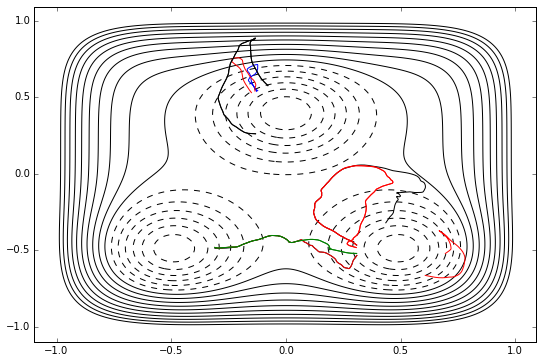

In [11]:
plot.plot([s.trajectory for s in gsA]+[s.trajectory for s in gsB]+[s.trajectory for s in gsC]);

In [12]:
total_sample_set = paths.SampleSet.relabel_replicas_per_ensemble([
        gsA, gsB, gsC
    ])

In [13]:
storage = paths.storage.Storage("mstis_bootstrap.nc", "w", template=template)

In [27]:
storage.save(total_sample_set)
storage.sync()

In [26]:
print "PathMovers:", len(storage.pathmovers)
print "Samples:", len(storage.samples)
print "Ensembles:", len(storage.ensembles)
print "SampleSets:", len(storage.samplesets)
print "Snapshots:", len(storage.snapshots)

PathMovers: 0
Samples: 12
Ensembles: 120
SampleSets: 1
Snapshots: 1246
